**CANDIDATE NUMBER: 55357**

### Import Modules & Prepare Data

In [1]:
# ML Modules
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, losses, Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional, Flatten, Input, LSTM, Concatenate, concatenate, LeakyReLU, Reshape, BatchNormalization
from keras.layers.convolutional import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils, plot_model

# Other
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Load & Batch Data

train_dataset = tf.data.Dataset.load('/content/drive/MyDrive/02 Education/03 MSc @ LSE/ST456 - Deep Learning/PS2/ST456_assignment2/assign2_train')
batch_size = 128
train_dataset_batch = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.load('/content/drive/MyDrive/02 Education/03 MSc @ LSE/ST456 - Deep Learning/PS2/ST456_assignment2/assign2_val')
val_dataset_batch = val_dataset.batch(batch_size)

In [3]:
## Data Preparation for P1.2

def reduce_dimension(x, y):
  return tf.squeeze(x, axis=-1), y

train_dataset_squeeze = train_dataset.map(reduce_dimension)
val_dataset_squeeze = val_dataset.map(reduce_dimension)

train_squeeze_batch = train_dataset_squeeze.batch(batch_size)
val_squeeze_batch = val_dataset_squeeze.batch(batch_size)

### P1 - Parallel CNNs and RNNs

#### P1.1

In [4]:
## Build Model

input_shape = Input(shape = (80, 80, 1), name = 'Input')
n_classes = 8

# First Branch
b1 = Conv2D(filters = 3, kernel_size = 8, padding = 'same', activation = LeakyReLU(alpha = 0.3), name = "B1_Conv2D") (input_shape)
b1 = MaxPooling2D(pool_size = 4, name = "B1_MaxPool") (b1)
b1 = Flatten(name = "B1_Flatten") (b1)

# Second Branch
b2 = Conv2D(filters = 4, kernel_size = 4, padding = 'same', activation = LeakyReLU(alpha = 0.3), name = "B2_Conv2D") (input_shape)
b2 = MaxPooling2D(pool_size = 2, name = "B2_MaxPool") (b2)
b2 = Flatten(name = "B2_Flatten") (b2)

# Merge Branches
merged = concatenate([b1, b2], name = "Concatenate")
merged = Dense(units = n_classes, activation = 'softmax', name = "Output_Dense") (merged)

model_11 = Model(input_shape, merged, name = "Model_11")
model_11.summary()

Model: "Model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 B1_Conv2D (Conv2D)             (None, 80, 80, 3)    195         ['Input[0][0]']                  
                                                                                                  
 B2_Conv2D (Conv2D)             (None, 80, 80, 4)    68          ['Input[0][0]']                  
                                                                                                  
 B1_MaxPool (MaxPooling2D)      (None, 20, 20, 3)    0           ['B1_Conv2D[0][0]']              
                                                                                           

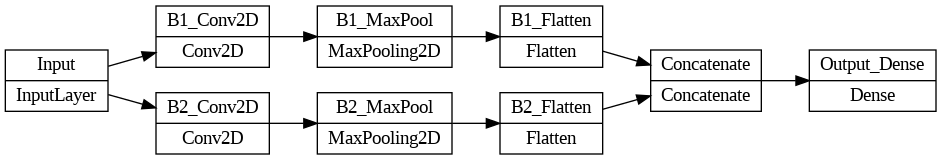

In [21]:
plot_model(model_11, rankdir="LR")

In [6]:
## Compile model

# Configure & compile model
optimSGD = keras.optimizers.SGD()
model_11.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = optimSGD)

In [7]:
## Train for 50 epochs

history_11 = model_11.fit(train_dataset_batch, epochs = 50, validation_data = val_dataset_batch)

Epoch 1/50
75/75 [==============================] - 21s 112ms/step - loss: 1.3877 - accuracy: 0.4876 - val_loss: 1.2055 - val_accuracy: 0.5350
Epoch 2/50
75/75 [==============================] - 1s 16ms/step - loss: 1.0902 - accuracy: 0.5977 - val_loss: 1.0832 - val_accuracy: 0.5817
Epoch 3/50
75/75 [==============================] - 1s 15ms/step - loss: 0.9712 - accuracy: 0.6439 - val_loss: 1.0135 - val_accuracy: 0.6137
Epoch 4/50
75/75 [==============================] - 1s 16ms/step - loss: 0.8895 - accuracy: 0.6772 - val_loss: 0.9646 - val_accuracy: 0.6417
Epoch 5/50
75/75 [==============================] - 1s 16ms/step - loss: 0.8261 - accuracy: 0.7001 - val_loss: 0.9268 - val_accuracy: 0.6554
Epoch 6/50
75/75 [==============================] - 2s 23ms/step - loss: 0.7738 - accuracy: 0.7226 - val_loss: 0.8952 - val_accuracy: 0.6729
Epoch 7/50
75/75 [==============================] - 2s 28ms/step - loss: 0.7287 - accuracy: 0.7401 - val_loss: 0.8678 - val_accuracy: 0.6817
Epoch 8/50


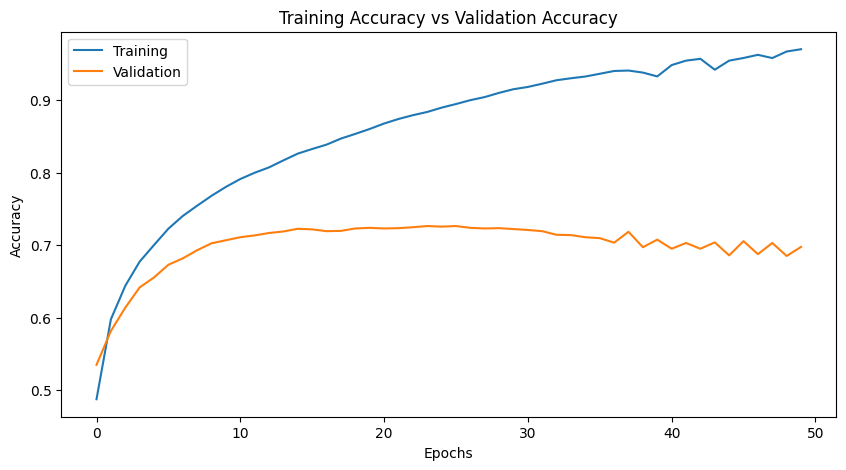

In [8]:
## Visualise training & validation accuracy over epochs
fig, axs = plt.subplots(1, 1, figsize=(10,5))
axs.plot(history_11.history['accuracy'])
axs.plot(history_11.history['val_accuracy'])
axs.title.set_text('Training Accuracy vs Validation Accuracy')
axs.legend(['Training', 'Validation'])
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy");

**Comment**

We can see the model's validation accuracy peaks at 0.7262 during epochs 20-25. After that accuracy declines suggesting that the model begins to overfit.

#### P1.2

In [9]:
## Build Model

model_12 = Sequential(name = 'Model_12')
model_12.add(Conv1D(filters = 8, kernel_size = 4, input_shape = (80,80), name = 'Conv_1'))
model_12.add(MaxPooling1D(pool_size = 2, name = 'MaxPool_1'))
model_12.add(Conv1D(filters = 6, kernel_size = 3, name = 'Conv_2'))
model_12.add(MaxPooling1D(pool_size = 2, name = 'MaxPool_2'))
model_12.add(LSTM(units = 128, return_sequences = True, name = 'LSTM_1'))
model_12.add(LSTM(units = 32, name = 'LSTM_2'))
model_12.add(Dense(units = 200, activation = "relu", name = 'Dense'))
model_12.add(Dropout(rate = 0.2, name = 'Dropout'))
model_12.add(Dense(units = 8, activation = 'softmax', name = 'Output_Dense'))

model_12.summary()

Model: "Model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 77, 8)             2568      
                                                                 
 MaxPool_1 (MaxPooling1D)    (None, 38, 8)             0         
                                                                 
 Conv_2 (Conv1D)             (None, 36, 6)             150       
                                                                 
 MaxPool_2 (MaxPooling1D)    (None, 18, 6)             0         
                                                                 
 LSTM_1 (LSTM)               (None, 18, 128)           69120     
                                                                 
 LSTM_2 (LSTM)               (None, 32)                20608     
                                                                 
 Dense (Dense)               (None, 200)               660

In [11]:
## Configure & compile model
optimSGD = keras.optimizers.SGD()
model_12.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = optimSGD)

In [12]:
## Train for 50 epochs

history_12 = model_12.fit(train_squeeze_batch, epochs = 50, validation_data = val_squeeze_batch)

Epoch 1/50
75/75 [==============================] - 8s 36ms/step - loss: 2.0500 - accuracy: 0.2026 - val_loss: 2.0231 - val_accuracy: 0.2404
Epoch 2/50
75/75 [==============================] - 4s 53ms/step - loss: 1.9891 - accuracy: 0.2504 - val_loss: 1.9668 - val_accuracy: 0.2350
Epoch 3/50
75/75 [==============================] - 2s 22ms/step - loss: 1.9348 - accuracy: 0.2498 - val_loss: 1.9258 - val_accuracy: 0.2354
Epoch 4/50
75/75 [==============================] - 2s 23ms/step - loss: 1.8991 - accuracy: 0.2534 - val_loss: 1.8972 - val_accuracy: 0.2412
Epoch 5/50
75/75 [==============================] - 2s 22ms/step - loss: 1.8730 - accuracy: 0.2578 - val_loss: 1.8753 - val_accuracy: 0.2492
Epoch 6/50
75/75 [==============================] - 2s 22ms/step - loss: 1.8516 - accuracy: 0.2689 - val_loss: 1.8568 - val_accuracy: 0.2592
Epoch 7/50
75/75 [==============================] - 2s 22ms/step - loss: 1.8337 - accuracy: 0.2767 - val_loss: 1.8408 - val_accuracy: 0.2700
Epoch 8/50
75

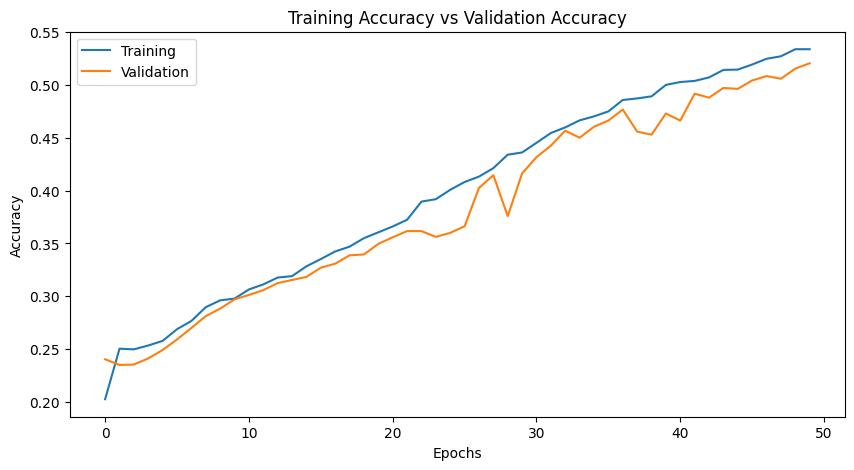

In [13]:
## Visualise training & validation accuracy over epochs
fig, axs = plt.subplots(1, 1, figsize=(10,5))
axs.plot(history_12.history['accuracy'])
axs.plot(history_12.history['val_accuracy'])
axs.title.set_text('Training Accuracy vs Validation Accuracy')
axs.legend(['Training', 'Validation'])
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy");

**Comment**

We can see that validation accuracy appears to improve linearly with the number of epochs, peaking at 0.5204 at the 50th epoch.

### P2

Given the stronger performance of the model from P1.1 (model_11) compared to P1.2, I worked from this as a baseline, and kept the same branched structure. This improved performance may be the result of branch specialisation, in which neurons 'self-organise' and group related functions into each branch.

I built on this model in several respects:
*   **Additional Convolutional Layers** | I increased the depth of the ANN with more convolutional layers, with the aim of making the model more able to learn low-level features of the spectograms. Moreover, I progressively increased the number of filters (32, 64, 128) and varied their size (8, 4, 8), to make the model better able to make abstractions from the data that are less influenced by noise from the raw input data.
*   **Pooling** | I reduced the pooling size to 2, with the aim of ensuring that not too much information is lost after each convolution round, while still reducing the dimensionality of the feature maps.
*   **Dropout** | I used this to add regularisation to the model and increased the dropout proportion with the depth of the model, with the aim of reducing model complexity and risk of overfitting.
*   **Bidirectional LSTM Layers** | I effectively replicated the model from P1.2 in the second branch but adapted it to be bidirectional, with the aim of adding in additional context from the 'future' to the model.
*   **Adam as Optimiser** | After tests with RMSprop and Batch SGD, this reliably produced the best results the most quickly.
*   **Exponentially Decaying Learning Rate** | I implemented this as I noticed on a few occasions the cross-validation accuracy jumping around in the later epochs (perhaps as the learning steps missed the minimum loss) - by getting a smaller learning rate as the training progresses, the solution is more likely to settle on the minimum. 

This resulted in the Cross Validation Accuracy peaking at 0.8950 in under 50 epochs.

With more time, I would have explored the impact o the followiing on this score:
*   Varying aspects of the dense and convolutional layers (e.g. including more dense layers of varying width and increasing the number of filters in the convolutional layers)
*   Data augmentation, using frequency masks or time masks (as normal transforms that may be used for images cannot apply to spectograms, as they would substantially alter its representation of the audio file).


In [14]:
## Build Model

input_shape = Input(shape = (80, 80, 1), name = 'Input')
n_classes = 8

# First Branch
b1 = Conv2D(filters = 32, kernel_size = 8, padding = 'same', activation = LeakyReLU(alpha = 0.3), name = 'B1_Conv_1') (input_shape)
b1 = MaxPooling2D(pool_size = 2, name = 'B1_MaxPool_1') (b1)
b1 = Dropout(rate = 0.2, name = 'B1_Dropout_1') (b1)
b1 = Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = LeakyReLU(alpha = 0.3), name = 'B1_Conv_2') (b1)
b1 = MaxPooling2D(pool_size = 2, name = 'B1_MaxPool_2') (b1)
b1 = Dropout(rate = 0.25, name = 'B1_Dropout_2') (b1)
b1 = Conv2D(filters = 128, kernel_size = 8, padding = 'same', activation = LeakyReLU(alpha = 0.3), name = 'B1_Conv_3') (b1)
b1 = MaxPooling2D(pool_size = 2, name = 'B1_MaxPool_3') (b1)
b1 = Dropout(rate = 0.3, name = 'B1_Dropout_3') (b1)
b1 = Flatten(name = "B1_Flatten") (b1)

# Second Branch
b2 = Reshape((80,80), input_shape = (80,80,1), name = 'B2_reshape') (input_shape)
b2 = Conv1D(filters = 8, kernel_size = 2, name = 'B2_Conv') (b2)
b2 = MaxPooling1D(pool_size = 2, name = 'B2_MaxPool') (b2)
b2 = Bidirectional(LSTM(units = 128, return_sequences = True, name = 'B2_LSTM_1'), name = 'B2_LSTMBi_1') (b2)
b2 = Bidirectional(LSTM(units = 32, name = 'B2_LSTM_2'), name = 'B2_LSTMBi_2') (b2)
b2 = Dense(units = 200, activation = "relu", name = 'B2_Dense') (b2)
b2 = Dropout(rate = 0.2, name = 'B2_Dropout') (b2)
b2 = Flatten(name = 'B2_Flatten') (b2)

# Merge Branches
merged = concatenate([b1, b2], name = "Concatenate")
merged = Dense(128, activation = "relu", name = 'Conc_Dense') (merged)
merged = Dropout(rate = 0.5, name = 'Conc_Dropout') (merged)
merged = Dense(units = n_classes, activation = 'softmax', name = "Output_Dense") (merged)

model_2 = Model(input_shape, merged, name = "Model_2")
model_2.reset_states()
model_2.summary()

Model: "Model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 B1_Conv_1 (Conv2D)             (None, 80, 80, 32)   2080        ['Input[0][0]']                  
                                                                                                  
 B1_MaxPool_1 (MaxPooling2D)    (None, 40, 40, 32)   0           ['B1_Conv_1[0][0]']              
                                                                                                  
 B1_Dropout_1 (Dropout)         (None, 40, 40, 32)   0           ['B1_MaxPool_1[0][0]']           
                                                                                            

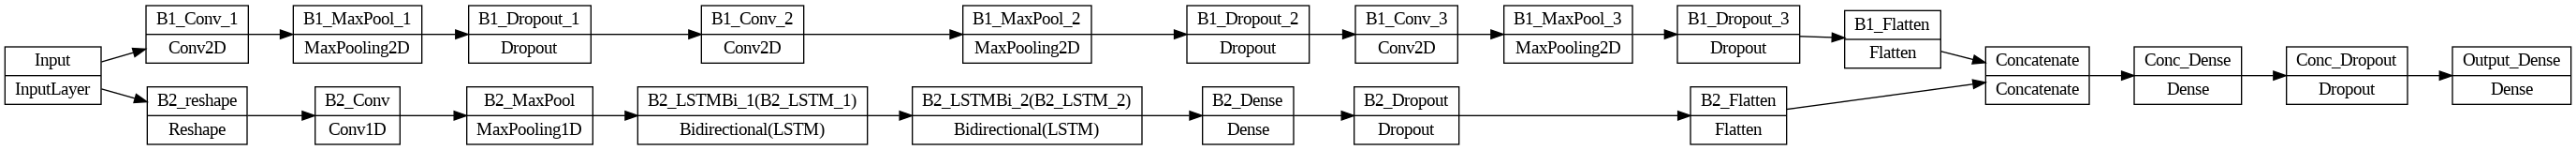

In [20]:
plot_model(model_2, rankdir="LR")

In [17]:
## Compile Model

# Use an exponentially decaying learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

# Configure & compile model
optimadam = keras.optimizers.Adam(learning_rate = lr_schedule)
model_2.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = optimadam)

In [18]:
## Train for 50 epochs

history_2 = model_2.fit(train_dataset_batch, epochs = 50, validation_data = val_dataset_batch)

Epoch 1/50
75/75 [==============================] - 19s 98ms/step - loss: 1.4884 - accuracy: 0.4519 - val_loss: 1.1478 - val_accuracy: 0.5904
Epoch 2/50
75/75 [==============================] - 5s 64ms/step - loss: 0.9497 - accuracy: 0.6542 - val_loss: 0.7969 - val_accuracy: 0.7196
Epoch 3/50
75/75 [==============================] - 5s 70ms/step - loss: 0.8002 - accuracy: 0.7167 - val_loss: 0.7495 - val_accuracy: 0.7467
Epoch 4/50
75/75 [==============================] - 5s 66ms/step - loss: 0.6720 - accuracy: 0.7571 - val_loss: 0.6233 - val_accuracy: 0.7783
Epoch 5/50
75/75 [==============================] - 5s 70ms/step - loss: 0.5487 - accuracy: 0.8025 - val_loss: 0.5548 - val_accuracy: 0.8117
Epoch 6/50
75/75 [==============================] - 5s 64ms/step - loss: 0.4773 - accuracy: 0.8289 - val_loss: 0.5035 - val_accuracy: 0.8246
Epoch 7/50
75/75 [==============================] - 5s 69ms/step - loss: 0.4281 - accuracy: 0.8503 - val_loss: 0.4701 - val_accuracy: 0.8354
Epoch 8/50
7

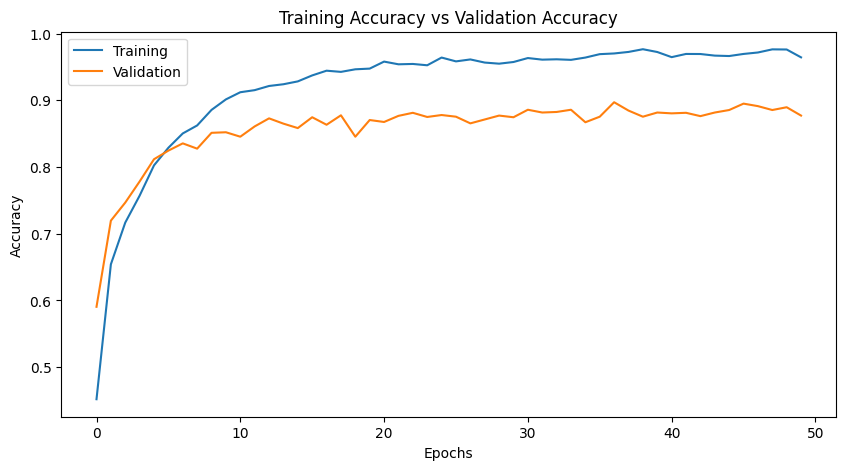

In [19]:
## Visualise training & validation accuracy over epochs
fig, axs = plt.subplots(1, 1, figsize=(10,5))
axs.plot(history_2.history['accuracy'])
axs.plot(history_2.history['val_accuracy'])
axs.title.set_text('Training Accuracy vs Validation Accuracy')
axs.legend(['Training', 'Validation'])
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy");